In [1]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import typing
import Functions.Help as helper
import Functions.Methods as methods

# Научимся делать n-граммы

Разделение происходит следующим образом:

1. Часть
2. Legit, Spam
3. Слова

In [2]:
parts_1 = []
parts_2 = []
parts_3 = []
spliter_1 = methods.NGramSpliter(1)
spliter_2 = methods.NGramSpliter(2)
spliter_3 = methods.NGramSpliter(3)

for i in range(1, 11):
    current_part = helper.read_part(i)
    parts_1.append((spliter_1.split(current_part[0]), spliter_1.split(current_part[1])))
    parts_2.append((spliter_2.split(current_part[0]), spliter_2.split(current_part[1])))
    parts_3.append((spliter_3.split(current_part[0]), spliter_3.split(current_part[1])))
parts_3[0][0][0]

{(80, 16502, 20010),
 (82, 18844, 23917),
 (84, 23266, 24097),
 (118, 1593, 13025),
 (118, 6782, 19604),
 (118, 20048, 1804),
 (130, 9887, 2130),
 (130, 23172, 9887),
 (1593, 13025, 6335),
 (1804, 118, 6782),
 (1847, 2130, 6049),
 (1967, 130, 23172),
 (1967, 12372, 1967),
 (2130, 6049, 130),
 (2130, 20010, 118),
 (2130, 23172, 84),
 (6049, 130, 9887),
 (6335, 16922, 23265),
 (6782, 19604, 118),
 (7634, 1847, 2130),
 (9561, -1, -1),
 (9887, 2130, 20010),
 (9887, 2130, 23172),
 (9887, 19054, 7634),
 (10092, 9561, -1),
 (12372, 1967, 130),
 (13025, 6335, 16922),
 (14338, 130, 9887),
 (16147, 17345, 14338),
 (16502, 20010, 10092),
 (16922, 23265, 82),
 (17345, 14338, 130),
 (18844, 23917, 16147),
 (19054, 7634, 1847),
 (19604, 118, 1593),
 (20010, 118, 20048),
 (20010, 10092, 9561),
 (20048, 1804, 118),
 (23172, 84, 23266),
 (23172, 9887, 19054),
 (23265, 82, 18844),
 (23266, 24097, 80),
 (23340, 1967, 12372),
 (23917, 16147, 17345),
 (24097, 80, 16502)}

In [3]:
counters_1 = []
counters_2 = []
counters_3 = []

for i in range(10):
    train_1 = []
    train_2 = []
    train_3 = []
    for j in range(10):
        if i != j:
            train_1.append(parts_1[j])
            train_2.append(parts_2[j])
            train_3.append(parts_3[j])
    counters_1.append(methods.Counter(train_1))
    counters_2.append(methods.Counter(train_2))
    counters_3.append(methods.Counter(train_3))

# А теперь начнём перебор!

In [4]:
import threading

alphas = np.exp(np.arange(start=-10, stop=11))
lambdas = np.arange(start=-15, stop=16)
ns = {1: (counters_1, parts_1), 2: (counters_2, parts_2), 3: (counters_3, parts_3)}


class BayesThread(threading.Thread):

    def __init__(self, n: int):
        self.optimal_alpha = alphas[0]
        self.optimal_lambda = lambdas[0]
        self.optimal_accuracy = 0
        self.n = n
        super().__init__()

    def run(self) -> None:
        for alpha in alphas:
            legits = []
            spams = []
            for index in range(10):
                counter = ns[self.n][0][index]
                counter.set_parameters(alpha=alpha)
                part = ns[self.n][1][index]
                legits.append([])
                for legit in part[0]:
                    legits[index].append(counter.predict(legit))
                spams.append([])
                for spam in part[1]:
                    spams[index].append(counter.predict(spam))
            for lambda_value in lambdas:
                can = True
                accuracies = []
                for index in range(10):
                    expected = []
                    actual = []
                    for probabilities in legits[index]:
                        expected.append(1)
                        if probabilities[0] + lambda_value > probabilities[1]:
                            actual.append(1)
                        else:
                            can = False
                            break
                    if not can:
                        break
                    for probabilities in spams[index]:
                        expected.append(0)
                        if probabilities[0] + lambda_value > probabilities[1]:
                            actual.append(1)
                        else:
                            actual.append(0)
                    accuracies.append(accuracy_score(expected, actual))
                if can:
                    accuracy = np.mean(accuracies)
                    if accuracy > self.optimal_accuracy:
                        self.optimal_accuracy = accuracy
                        self.optimal_alpha = alpha
                        self.optimal_lambda = lambda_value

In [5]:
from sklearn.metrics import accuracy_score

optimal_alpha = alphas[0]
optimal_lambda = lambdas[0]
optimal_n = 1
optimal_accuracy = 0

thread_1 = BayesThread(1)
thread_1.start()

thread_2 = BayesThread(2)
thread_2.start()

thread_3 = BayesThread(3)
thread_3.start()

thread_1.join()
thread_2.join()
thread_3.join()

if thread_1.optimal_accuracy > optimal_accuracy:
    optimal_accuracy = thread_1.optimal_accuracy
    optimal_n = 1
    optimal_lambda = thread_1.optimal_lambda
    optimal_alpha = thread_1.optimal_alpha

if thread_2.optimal_accuracy > optimal_accuracy:
    optimal_accuracy = thread_2.optimal_accuracy
    optimal_n = 2
    optimal_lambda = thread_2.optimal_lambda
    optimal_alpha = thread_2.optimal_alpha

if thread_3.optimal_accuracy > optimal_accuracy:
    optimal_accuracy = thread_3.optimal_accuracy
    optimal_n = 3
    optimal_lambda = thread_3.optimal_lambda
    optimal_alpha = thread_3.optimal_alpha

print(
    f'Оптимальные параметры alpha = {optimal_alpha}, lambda = e^{optimal_lambda}, n = {optimal_n}, accuracy = {optimal_accuracy}')

Оптимальные параметры alpha = 0.049787068367863944, lambda = e^7, n = 3, accuracy = 0.863302752293578


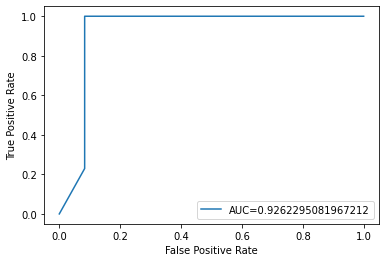

In [6]:
from sklearn.metrics import roc_curve, roc_auc_score

optimal_counter = counters_3[0]
optimal_counter.set_parameters(alpha=optimal_alpha)
test_part = parts_3[0]
y_test = []
y_prob = []
for legit_test in test_part[0]:
    y_test.append(1)
    legit_prob, spam_prob = optimal_counter.predict(legit_test)
    y_prob.append(methods.calculate(legit_prob + optimal_lambda, spam_prob))
for spam_test in test_part[1]:
    y_test.append(0)
    legit_prob, spam_prob = optimal_counter.predict(spam_test)
    y_prob.append(methods.calculate(legit_prob + optimal_lambda, spam_prob))

fpr, tpr, _ = roc_curve(y_true=y_test, y_score=y_prob)
auc = roc_auc_score(y_true=y_test, y_score=y_prob)

plt.plot(fpr, tpr, label="AUC=" + str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

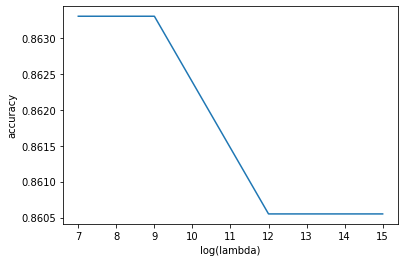

In [7]:
acc = []
lambda_values = []
legits = []
spams = []

for index in range(10):
    counter = counters_3[index]
    counter.set_parameters(optimal_alpha)
    part = parts_3[index]
    legits.append([])
    for legit in part[0]:
        legits[index].append(counter.predict(legit))
    spams.append([])
    for spam in part[1]:
        spams[index].append(counter.predict(spam))
for lambda_value in lambdas:
    can = True
    accuracies = []
    for index in range(10):
        expected = []
        actual = []
        for probabilities in legits[index]:
            expected.append(1)
            if probabilities[0] + lambda_value > probabilities[1]:
                actual.append(1)
            else:
                can = False
                break
        if not can:
            break
        for probabilities in spams[index]:
            expected.append(0)
            if probabilities[0] + lambda_value > probabilities[1]:
                actual.append(1)
            else:
                actual.append(0)
        accuracies.append(accuracy_score(expected, actual))
    if can:
        acc.append(np.mean(accuracies))
        lambda_values.append(lambda_value)

plt.plot(lambda_values, acc)
plt.xlabel('log(lambda)')
plt.ylabel('accuracy')
plt.show()